In [1]:
import jellyfish as jl
import pandas as pd
import json
import numpy as np

## Chargement des indicateurs

In [2]:
with open('data/indicators_lists.json') as data_file:
    data = json.load(data_file)

In [43]:
indicateurs_kivu = data['kivu']
indicateurs_rca = data['rca']

def get_list_indics(indicateurs_pays) :
    indicateurs = []
    for t in ['pma' , 'pca'] :
        indics = indicateurs_pays[t]
        for u in indics.keys() :
            lib = indics[u]['lib']
            indicateurs.append(lib)
    return indicateurs

indicateurs_libs_rca = get_list_indics(indicateurs_rca)
indicateurs_libs_kivu = get_list_indics(indicateurs_kivu)

all_indicateurs = indicateurs_libs_rca
for i in range(len(indicateurs_libs_kivu)) :
    all_indicateurs.append(indicateurs_libs_kivu[i])

## Approche 1 : Distance Jaro

Première approche : on regarde la [distance Jaro](https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance) qui est juste une mesure de la distance entre les chaines de caractère 

In [4]:
def get_closest_jaro(indicateur , list_indicateurs):
    distances = {}
    for i in range(len(list_indicateurs)):
        jro = jl.jaro_distance(indicateur , list_indicateurs[i])
        distances[list_indicateurs[i]] = jro
    print(indicateur)
    print(sorted(distances, key=distances.get , reverse = True))
    return(distances)

In [44]:
get_closest_jaro(indicateurs_libs_rca[19] , indicateurs_libs_kivu)

Enfants completement vaccines
['Enfants completement vaccines', 'Contre referes avec documents', 'Enfant 12 a 59 mois ayant realise 4 visites standards (1/trim)', 'Indigent ayant recu Implants ou DIU', 'Consultations externes', 'PF Naturelle nouvelles inscrites', 'Femme enceinte ayant recu VAT 2+', 'Enfant de 12 a 59 mois inscrit a la CPS 2', 'Autres accouchements dystociques (cesariennes exclues)', 'Consultations externes (nvx cas de victime  des violences sexuelles traites dans 72h)', 'PF Naturelle nouvelles inscrites couples autonomes', 'Cesariennes (30% des accouchements dystociques)', 'PF: Ligatures et vasectomies', 'Nombre de retro-informations arrivees', 'Pilule + Inj (Anc acceptantes) (si score qualite >ou= a 60%)', 'Pilule + Inj (Nouv acceptantes) (si score qualite >ou= a 60%)', 'NC Indigent nouvelle utilisatrice (Pillule+Injection)', 'Nombre des visites a  domicile realisees', "Nombre de reunions d'echange avec les jeunes  et  adolescents de 10 a   24 ans organise au CS", "No

{'Accouchements assistes avec 3 CPN (si score qualite > ou = a 60%)': 0.5236747926403099,
 'Accouchements assistes dans FOSA (si score qualite >ou= a 60%)': 0.5288857107544538,
 'Accouchements dystociques avec 3 CPN (si score qualite > ou = a 60%)': 0.5189236614185905,
 'Autres accouchements dystociques (cesariennes exclues)': 0.5856457293238903,
 'CPN 3 visites standards accomplies': 0.549104124408384,
 'CPN au 4eme mois (debut T2)': 0.4527458492975734,
 'CPN: 2eme visite au 42e jour': 0.4752326217843459,
 "Cas de VVS Referes  et arrivees a  l'Hopital": 0.48126586057620546,
 'Cesariennes (30% des accouchements dystociques)': 0.580791671033784,
 'Cesariennes avec 3 CPN': 0.5258821638131983,
 'Consultations externes': 0.5996865203761755,
 'Consultations externes (nvx cas de victime  des violences sexuelles traites dans 72h)': 0.585395537525355,
 'Contre referes avec documents': 0.6297640653357531,
 'Enfant 12 a 59 mois ayant realise 4 visites standards (1/trim)': 0.6199077880414632,
 'E

## Approche 2: Latent Semantic Indexing

Seconde approche, en utilisant une analyse du vocabulaire utilisé. Idée et une bonne partie du code trouvés chez [Ryan Lambert](http://www.ryanglambert.com/blog/latent-semantic-indexing-how-i-built-pubmatchco). 

### Keywords extraction

Dans un premier temps, on veut extraire les mots importants du libelle des indicateurs. Fait pour le français avec le model Part of Speach pour le français rendu dispo par une équipe de Stanford.

In [6]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag.stanford import StanfordPOSTagger

import os
os.environ["JAVAHOME"] = 'C:\\Program Files (x86)\\Java\\jre1.8.0_91\\bin'

wd = 'C:\\Users\\Grlurton\\Documents\\indicators_tagging\\'

path_to_french_model = wd + "data\\stanford-postagger-full-2015-12-09\\stanford-postagger-full-2015-12-09\\models\\french.tagger"
path_to_jar = wd + 'data\\stanford-postagger-full-2015-12-09\\stanford-postagger-full-2015-12-09\\stanford-postagger.jar'

french_tagger = StanfordPOSTagger(path_to_french_model, path_to_jar, encoding="utf-8")

In [7]:
def tokenize_and_tag_indicators(indicateur):
    tagged_indicator = french_tagger.tag(word_tokenize(indicateur))
    return tagged_indicator

def keep_important_words(tagged_indicator):
    noms = []
    for n in range(len(tagged_indicator)) :
        tag = tagged_indicator[n][1]
        if tag in ['NN','NNS','NNP','JJ','RB','VB','N','NPP','V','NC','ADJ']:
            noms.append(tagged_indicator[n][0])
    return noms
            
def wrapper_indicators_extract(indicateur):
    tagged_indicator = tokenize_and_tag_indicators(indicateur)
    key_words = keep_important_words(tagged_indicator)
    return key_words

In [8]:
key_words = []
for i in range(len(all_indicateurs)) :
    words = wrapper_indicators_extract(all_indicateurs[i])
    for w in words :
        key_words.append(w)
        
key_words = pd.Series(key_words)
key_words = key_words.unique()

### Additional Processing of keywords

En regardant les premiers résultats, il semble qu'on ait des situations un peu problématique, comme 

1. des singuliers / pluriels qui seront pris comme des mots différents
2. des mots non sécifiques ("nombre de") qui peuvent nuire à l'analyse
3. les synonymes utilisés ou termes différents dans différents pays

Quelques pistes pour corriger ça.

1. Pour les versions différentes d'un même mot avec pluriel, juste recherche avec distance Levenshtein qui devrait permettre de trouver les mots trop proches
2. ??
3. ...

In [45]:
len(key_words)

233

### LSI proprement dite

In [10]:
a = []
for indicateur in all_indicateurs :
    default = np.zeros(len(key_words))
    words = word_tokenize(indicateur)
    for i in range(len(key_words)):
        if key_words[i] in words :
            default[i] = 1
    a.append(default.tolist())

a = np.asarray(a)

In [12]:
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from scipy.sparse.linalg import svds as SVDS
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import distance_metrics 
from sklearn.metrics.pairwise import pairwise_distances
import seaborn as sns

%matplotlib inline

In [13]:
docs, eigen_roots, terms_T = SVDS(a, k=2)

In [14]:
list_of_concepts = []
for principal_component in terms_T:
    concept_dict = {}
    for index, j in enumerate(principal_component):
        concept_dict[key_words[index]] = j
    list_of_concepts.append(concept_dict)

In [15]:
def find_closest(indicator_num):
    dist  = 1
    min_dist = 0
    for j in range(len(all_indicateurs)):
        if j != indicator_num :
            d = pdist((docs[indicator_num, :],docs[j, :]))
            if d < dist :
                dist = d
                min_dist = j
    print(all_indicateurs[indicator_num])
    print('       ' + all_indicateurs[min_dist])
    return min_dist

In [38]:
find_closest(21)

VIH, personne testee
       Contre referes avec documents


105

In [40]:
a_quiver = np.concatenate((np.asarray([[0, 0]]*len(all_indicateurs)), docs),axis=1)

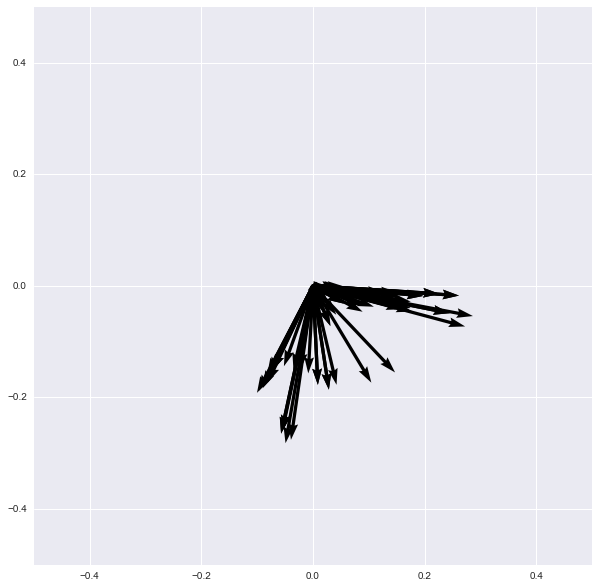

In [41]:
import numpy as np
import matplotlib.pyplot as plt

soa = a_quiver
X,Y,U,V = zip(*soa)
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.quiver(X,Y,U,V,angles='xy',scale_units='xy',scale=1)
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.5,0.5])
plt.draw()
plt.show()

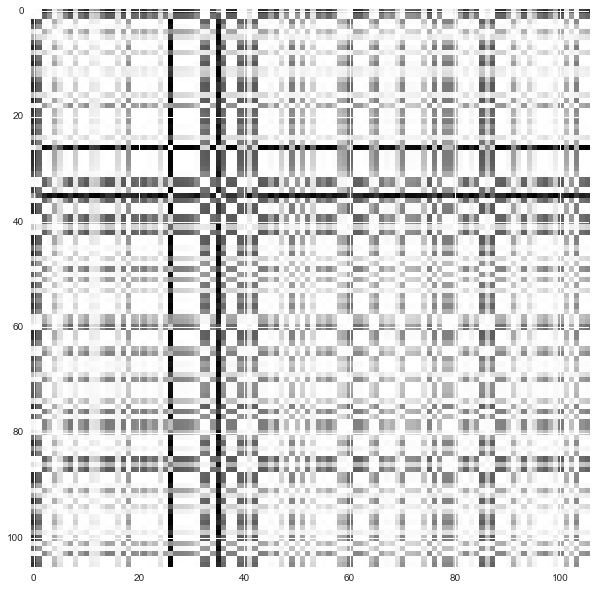

In [42]:
plt.figure(figsize= (10, 10))
plt.imshow(pairwise_distances(docs, metric='cosine'), interpolation='nearest')
plt.savefig('cosine_similarity_bacon_books.png')
plt.show()